Silhouette Score for Hierarchical Clustering: 0.630831569464452
Davies-Bouldin Score for Hierarchical Clustering: 0.518154942820026
Silhouette Score for KMeans: 0.6421949053751135
Davies-Bouldin Score for KMeans: 0.5073488222631952
Silhouette Score for GMM: 0.570212169856418
Davies-Bouldin Score for GMM: 0.5213658515577522
Hierarchical Cluster Summary:
                      A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  \
hierarchical_cluster                                                     
0                     0.619048  0.761905  0.619048  0.571429   0.52381   
1                     0.555556  0.592593  0.574074  0.444444   0.50000   
2                     0.576000  0.504000  0.408000  0.392000   0.41600   

                      A6_Score  A7_Score  A8_Score  A9_Score  A10_Score  ...  \
hierarchical_cluster                                                     ...   
0                     0.666667  0.523810  0.619048  0.666667   0.714286  ...   
1                     0.370370  0.

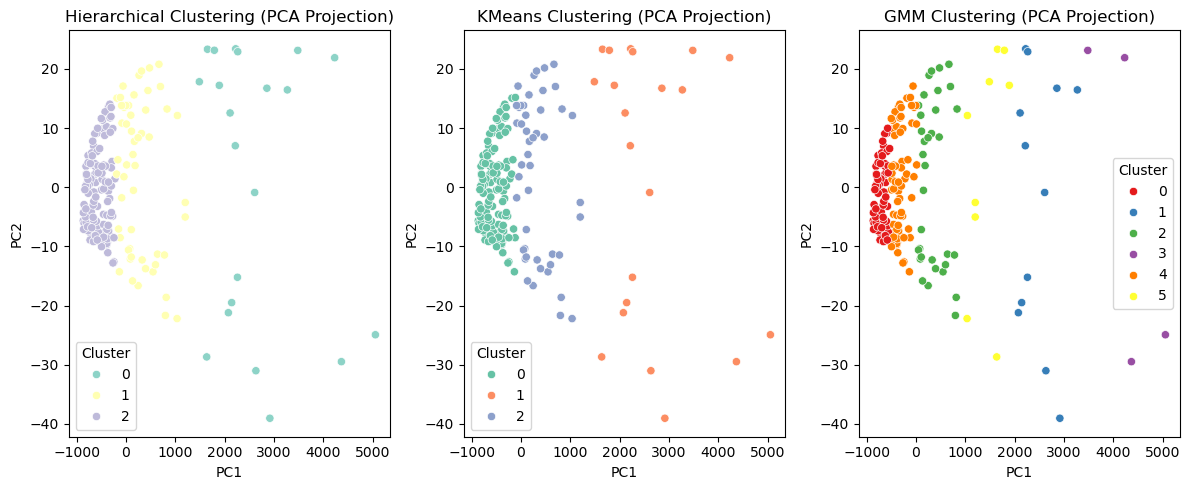

In [6]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
%run dataInfo.ipynb

cleanTest = test_df
cleanTrain = train_df #doesn't have asd/class

# Drop train class column
cleanTrain = cleanTrain.drop(columns=['Class/ASD'])
cleanTrain = cleanTrain.loc[:, ~cleanTrain.columns.str.startswith('relation_')]
cleanTest = cleanTest.loc[:, ~cleanTest.columns.str.startswith('relation_')]


# Combine train and test data for preprocessing
combined_df = pd.concat([cleanTrain, cleanTest], axis=0)
combined = combined_df.dropna()

#Engineer Composite Features

# Create a new feature 'mean_A_score' by averaging the scores of A1 to A10
score_cols = [f"A{i}_Score" for i in range(1, 11)]
combined['mean_A_score'] = combined[score_cols].mean(axis=1)

# score times age
combined['age_x_mean_A'] = combined['age'] * combined['mean_A_score']

# Polynomial features (squared terms)
combined['age_squared'] = combined['age'] ** 2
combined['mean_A_score_squared'] = combined['mean_A_score'] ** 2

#dont use scaler bc it makes it worse

# run the hierarchical clustering
model = AgglomerativeClustering(n_clusters=3, linkage='ward')  # Choose the number of clusters you want (e.g., 3)
combined['hierarchical_cluster'] = model.fit_predict(combined)
hierarchical_siloutte = silhouette_score(combined, combined['hierarchical_cluster'])
print(f"Silhouette Score for Hierarchical Clustering: {hierarchical_siloutte}")
db_hierarchical = davies_bouldin_score(combined, combined['hierarchical_cluster'])
print(f"Davies-Bouldin Score for Hierarchical Clustering: {db_hierarchical}")

#run the clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_clusters = kmeans.fit_predict(combined)
kmeans_silhouette = silhouette_score(combined, kmeans_clusters)
print(f"Silhouette Score for KMeans: {kmeans_silhouette}")
db_kmeans = davies_bouldin_score(combined, kmeans_clusters)
print(f"Davies-Bouldin Score for KMeans: {db_kmeans}")

# Let's say you want to try different cluster numbers (e.g., 3 or 4)
gmm = GaussianMixture(n_components=6, random_state=42)  # n_components is the number of clusters
gmm_clusters = gmm.fit_predict(combined)  # Fit the model and predict cluster labels
gmm_silhouette = silhouette_score(combined, gmm_clusters)
print(f"Silhouette Score for GMM: {gmm_silhouette}")
db_gmm = davies_bouldin_score(combined, gmm_clusters)
print(f"Davies-Bouldin Score for GMM: {db_gmm}")


# Add cluster labels to the combined DataFrame
combined['kmeans_cluster'] = kmeans_clusters
combined['gmm_cluster'] = gmm_clusters
combined['hierarchical_cluster'] = combined['hierarchical_cluster']

kmeans_cluster_summary = combined.groupby('kmeans_cluster').mean()
gmm_cluster_summary = combined.groupby('gmm_cluster').mean()
cluster_summary = combined.groupby('hierarchical_cluster').mean()  # Shows mean of each feature per cluster
# Print silhouette scores



#Print cluster summaries
print("Hierarchical Cluster Summary:")
print(cluster_summary)

print("KMeans Cluster Summary:")
print(kmeans_cluster_summary)

print("GMM Cluster Summary:")
print(gmm_cluster_summary)

# Reduce dimensionality
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(combined.drop(columns=['kmeans_cluster', 'gmm_cluster']))

# Convert to DataFrame
pca_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])

# Add cluster labels back in
if 'kmeans_cluster' in combined.columns:
    pca_df['kmeans_cluster'] = combined['kmeans_cluster'].values
if 'gmm_cluster' in combined.columns:
    pca_df['gmm_cluster'] = combined['gmm_cluster'].values
if 'hierarchical_cluster' in combined.columns:
    pca_df['hierarchical_cluster'] = combined['hierarchical_cluster'].values

#kmeans
plt.figure(figsize=(12, 5))

#Hierarchical
plt.subplot(1, 3, 1)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='hierarchical_cluster', palette='Set3')
plt.title('Hierarchical Clustering (PCA Projection)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')

# KMeans
plt.subplot(1, 3, 2)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='kmeans_cluster', palette='Set2')
plt.title('KMeans Clustering (PCA Projection)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')

# GMM
plt.subplot(1, 3, 3)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='gmm_cluster', palette='Set1')
plt.title('GMM Clustering (PCA Projection)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')

plt.tight_layout()
plt.show()

